In [1]:
import warnings

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplfinance as mpf

from yahoo_fin_api import load_df
from fin_viz import candlechart
from denoising.traditional_denoising import moving_avg, exp_moving_avg, bilateral_filter
from metrics import *

%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
df = load_df('data/snp.csv')

In [3]:
ma_filtered = moving_avg(df['Mean'], window=300)
ema_filtered = exp_moving_avg(df['Mean'], adjust=False, span=100)
bilateral_filtered = bilateral_filter(df['Mean'], window=301, sigma_d=100, sigma_i=1000)

bilateral_filtered = pd.Series(bilateral_filtered, index=df.index)

In [4]:
trad_filt_df = pd.DataFrame()
trad_filt_df['True'] = df['Mean']
trad_filt_df['MA_filtered'] = ma_filtered
trad_filt_df['EMA_filtered'] = ema_filtered
trad_filt_df['bilateral_filtered'] = bilateral_filtered
trad_filt_df.to_csv('trad_filter_df.csv')

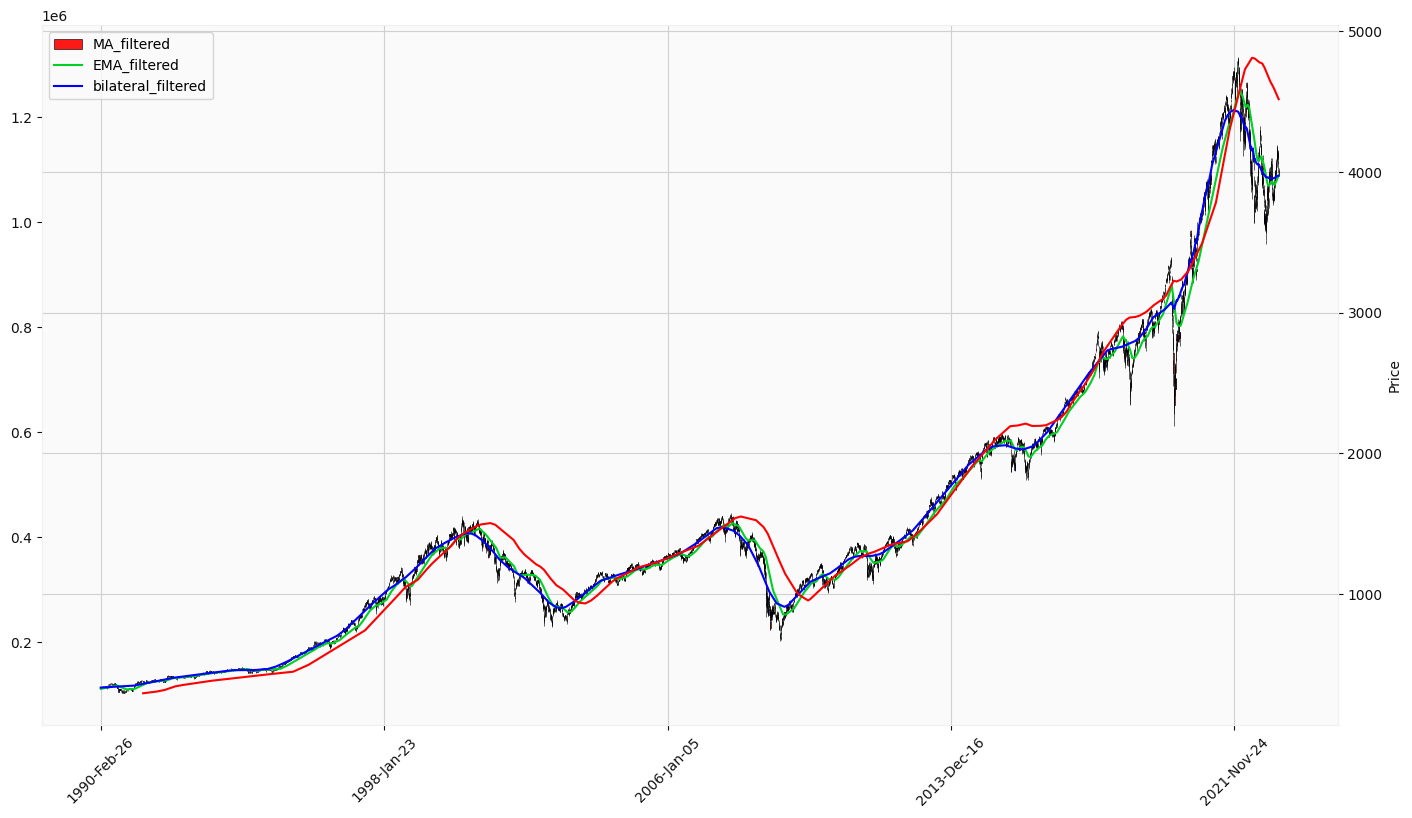

In [5]:
add_plots = {
    'MA_filtered': mpf.make_addplot(ma_filtered, type='line', color='r', width=1.5),
    'EMA_filtered': mpf.make_addplot(ema_filtered, type='line', color='#00d024', width=1.5),
    'bilateral_filtered': mpf.make_addplot(bilateral_filtered, type='line', color='b', width=1.5),
}

fig, ax = candlechart(df, addplot=list(add_plots.values()))
fig.set_size_inches(18, 10)

ax[0].legend([None] * (len(add_plots) + 2))
handles = ax[0].get_legend().legendHandles
ax[0].legend(handles=handles[1:], labels=list(add_plots.keys()))

## Metrics

In [6]:
trad_filt_df.isna().sum()

True                    0
MA_filtered           299
EMA_filtered            0
bilateral_filtered      0
dtype: int64

In [7]:
ma_filt_df = trad_filt_df[['True', 'MA_filtered']].dropna(axis=0)
ema_filt_df = trad_filt_df[['True', 'EMA_filtered']].dropna(axis=0)
bilateral_filt_df = trad_filt_df[['True', 'bilateral_filtered']].dropna(axis=0)

In [8]:
def get_metrics(metrics_dict, filt_df_dict):
    result_dict = dict()
    result_dict['Filter'] = []
    for metric_name in metrics_dict:
        result_dict[metric_name] = []
    
    for filt_df_name in filt_df_dict:
        result_dict['Filter'].append(filt_df_name)

        filt_df = filt_df_dict[filt_df_name]
        y_true = filt_df['True']
        y_pred = filt_df.drop('True', axis=1).iloc[:, 0]        
        for metric_name in metrics_dict:
            metric_func = metrics_dict[metric_name]
            result_dict[metric_name].append(
                metric_func(y_true, y_pred)
            )
    
    return pd.DataFrame(result_dict)

In [9]:
metrics_dict = {
    'mean_squared_error': mean_squared_error,
    'r2_score': r2_score,
    'snr': snr,
    'psnr': psnr,
    'ssim': ssim,
}

filt_df_dict = {
    'MA': ma_filt_df,
    'EMA': ema_filt_df,
    'Bilateral': bilateral_filt_df
}

get_metrics(metrics_dict, filt_df_dict)

,Filter,mean_squared_error,r2_score,snr,psnr,ssim
0,MA,2.797419e+11,-279636.368342,-49.099719,7.911767,NaN
1,EMA,7.825442e+03,0.992299,26.279190,34.685636,NaN
2,Bilateral,4.929928e+03,0.995148,28.285874,36.692320,NaN
